In [1]:
import sys
sys.path.append('../code')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
import read_video as rv
import reconstruction_utils as ru

In [4]:
import reconstruction as rec

In [5]:
#filepath = 'F:/LiverCells/Holo_mod_5fpsEvery1_6/Holo_mod_5fpsEvery1_6_holo.avi'

#filepath = 'F:/CellsLNPs/CellLNPs2hIncubation_t1_Every1_3/CellLNPs2hIncubation_t1_Every1_3_holo.avi'

#filepath = 'F:/PSLinOil/PSL450nmOnGlassInImmersionOil_thickLFAF_severalSteps_Every1_2/PSL450nmOnGlassInImmersionOil_thickLFAF_severalSteps_Every1_2_holo.avi'

filepath = 'F:/7juli/FluoSilica_7h_10fps_3msExp_mod07_noFilter_Every1_1/FluoSilica_7h_10fps_3msExp_mod07_noFilter_Every1_1_holo.avi'

In [6]:
data = rv.read_video(filepath, 0, 50)

In [7]:
data.shape

(50, 1450, 1930)

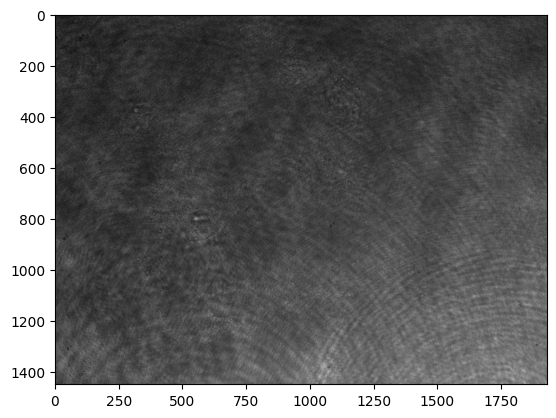

In [8]:
plt.imshow(data[0], cmap='gray')

In [10]:
frame = data[0]

In [11]:
co = rec.HolographicReconstruction()
co.first_image = torch.tensor(frame)
co.mask_radiis = [10, 10]
co.lowpass_filtered_phase = None
co.skip_background_correction=True
co.crop=0
co.phase_corrections = 2

In [12]:
co.precalculations()

In [13]:
data = torch.tensor(data).to('cuda')

In [14]:
datan = co.forward(data)

Reconstructing 50 holograms.


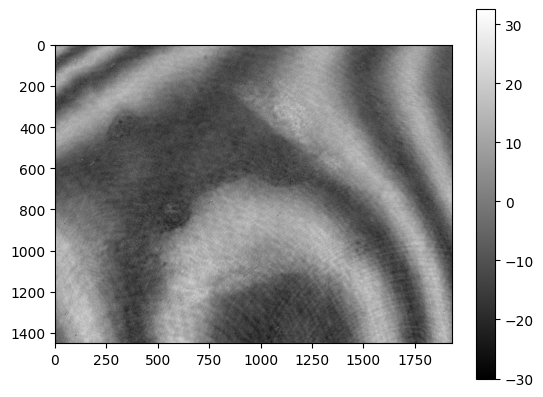

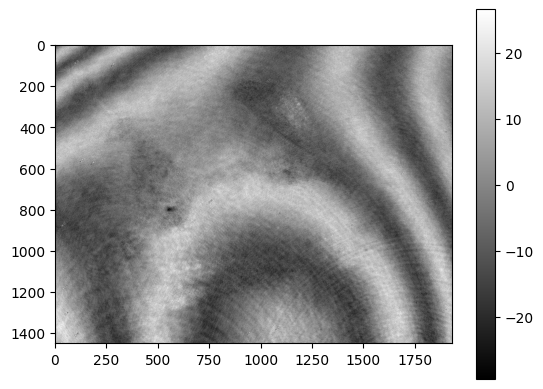

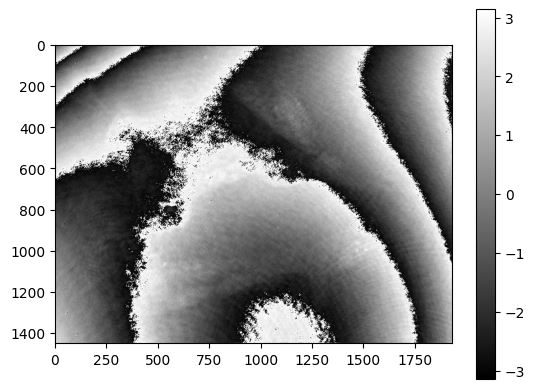

In [15]:
plt.imshow(co.first_field.real.npu().numpy(), cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(co.first_field_corrected.imag.npu().numpy(), cmap='gray')
plt.colorbar()
plt.figure()
plt.imshow(torch.angle(co.first_field_corrected).npu().numpy(), cmap='gray')
plt.colorbar()

In [16]:
co.first_field_corrected.shape

torch.Size([1450, 1930])

In [18]:
input_shape = co.first_field_corrected.shape

In [20]:
def get_4th_polynomial(input_shape):
    """
    Function that retrieves the 4th-order polynomial

    Input:
        input_shape : Shape of matrix
    Output :
        Polynomial matrix. 

    """
    yrc, xrc = input_shape

    xc = np.arange(-(xrc/2-1/2), (xrc/2 + 1/2), 1)
    yc = np.arange(-(yrc/2-1/2), (yrc/2 + 1/2), 1)
    Y_c, X_c = np.meshgrid(xc, yc)

    #4th order polynomial.
    polynomial = [
                    X_c**2, 
                    X_c*Y_c, 
                    Y_c**2, 
                    X_c, 
                    Y_c, 
                    X_c**3, 
                    X_c**2*Y_c, 
                    X_c*Y_c**2,
                    Y_c**3, 
                    X_c**4, 
                    X_c**3*Y_c, 
                    X_c**2*Y_c**2, 
                    X_c*Y_c**3, 
                    Y_c**4
                ]

    return polynomial

def get_G_matrix (input_shape):
    """
    Input:
        input_shape : Shape of matrix
    Output:
        Matrix to store 4-order polynominal. (Not including constant)
    """

    yrc, xrc = input_shape

    xc = np.arange(-(xrc/2-1/2), (xrc/2 + 1/2), 1)
    yc = np.arange(-(yrc/2-1/2), (yrc/2 + 1/2), 1)
    Y_c, X_c = np.meshgrid(xc, yc)

    #Vectors of equal size. x1 and y1 spatial coordinates
    x1 = 1/2 * ((X_c[1:, 1:] + X_c[:-1, :-1])).flatten(order='F')
    y1 = 1/2 * ((Y_c[1:, 1:] + Y_c[:-1, :-1])).flatten(order='F')
    
    G = np.zeros((2 * (xrc-1) * (yrc-1) , 14)) # Matrix to store 4-order polynominal. (Not including constant)
    G_end = G.shape[0]
    #(derivate w.r.t to X and Y respectively.)
    uneven_range = np.arange(1, G_end+1, 2)
    even_range = np.arange(0, G_end, 2)
    
    G[uneven_range, 4] = 1
    G[even_range, 3] = 1
    G[even_range, 1] = y1
    G[even_range, 0] = 2*x1
    G[uneven_range, 1] = x1
    G[uneven_range, 2] = 2*y1
    
    G[even_range, 5] = 3*x1**2
    G[even_range, 6] = 2*x1*y1
    G[uneven_range, 6] = x1**2
    G[uneven_range, 7] = 2*x1*y1
    G[even_range, 7] = y1**2
    G[uneven_range, 8] = 3*y1**2
    
    G[even_range, 9] = 4*x1**3
    G[even_range, 10] = 3*x1**2*y1
    G[uneven_range, 10] = x1**3
    G[even_range, 11] = 2*x1*y1**2
    G[uneven_range, 11] = 2*x1**2*y1
    G[even_range, 12] = y1**3
    G[uneven_range, 12] = 3*x1*y1**2
    G[uneven_range, 13] = 4*y1**3

    return G

In [21]:
poly = get_4th_polynomial(input_shape)
G = get_G_matrix(input_shape)

In [22]:
poly

[array([[524900.25, 524900.25, 524900.25, ..., 524900.25, 524900.25,
         524900.25],
        [523452.25, 523452.25, 523452.25, ..., 523452.25, 523452.25,
         523452.25],
        [522006.25, 522006.25, 522006.25, ..., 522006.25, 522006.25,
         522006.25],
        ...,
        [522006.25, 522006.25, 522006.25, ..., 522006.25, 522006.25,
         522006.25],
        [523452.25, 523452.25, 523452.25, ..., 523452.25, 523452.25,
         523452.25],
        [524900.25, 524900.25, 524900.25, ..., 524900.25, 524900.25,
         524900.25]]),
 array([[ 698780.25,  698055.75,  697331.25, ..., -697331.25, -698055.75,
         -698780.25],
        [ 697815.75,  697092.25,  696368.75, ..., -696368.75, -697092.25,
         -697815.75],
        [ 696851.25,  696128.75,  695406.25, ..., -695406.25, -696128.75,
         -696851.25],
        ...,
        [-696851.25, -696128.75, -695406.25, ...,  695406.25,  696128.75,
          696851.25],
        [-697815.75, -697092.25, -696368.75, ...

In [27]:
def correct_phase_4order(phase_img, G, polynomial):
    """ 
    Calculates the coefficients (4th order) by taking the derivative of phase image to fit an phase background. 

    Input: 
        phase_img : phase image
        G : Matrix that store 4-order polynominal
        polynomial : polynomial matrix of meshes
    Output: 
        Phase bakground fit

    """
    An0 = phase_img.copy()
    yr, xr = An0.shape

    An0 = An0 - An0[0, 0] #Set phase to "0"

    # Derivative the phase to handle the modulus
    dx = -np.pi + np.mod(np.pi + (np.diff(An0, axis = 0)), 2*np.pi)
    dy = -np.pi + np.transpose(np.mod(np.pi + np.transpose((np.diff(An0))), 2*np.pi))
    
    #dx1, dy1 the derivatives
    dx1 = 1/2 * ((dx[:, 1:] + dx[:, :-1])).flatten(order='F')
    dy1 = 1/2 * ((dy[1:, :] + dy[:-1, :])).flatten(order='F')

    #(derivate w.r.t to X and Y respectively.) Each factor have a constant b_i to be fitted later on.
    G_end = G.shape[0]
    uneven_range = np.arange(1, G_end+1, 2)
    even_range = np.arange(0, G_end, 2)
    
    dt = np.zeros(2 * (xr-1) * (yr-1))
    dt[even_range] = dx1
    dt[uneven_range] = dy1          
    
    # Here the coefficients to the polonomial are calculated. Note that np.linalg.lstsq(b,B)[0] is equivivalent to \ in MATLAB              
    R = np.transpose(np.linalg.cholesky(np.matmul(np.transpose(G),G)))
    
    # Equivivalent to R\(R'\(G'*dt))
    b = np.linalg.lstsq(R, 
                        np.linalg.lstsq(np.transpose(R),
                                        np.matmul(np.transpose(G),dt), rcond=None)[0], rcond=None)[0]
    b = np.asarray(b)

    # Phase background is defined by the 4th order polynomial with the fitted parameters.
    phase_background = 0
    for i, factor in enumerate(polynomial):
        phase_background = phase_background + b[i]*factor
    
    return phase_background

In [28]:
bg = correct_phase_4order(torch.angle(co.first_field_corrected).cpu().numpy(), torch.tensor(G).cpu().numpy(), poly)

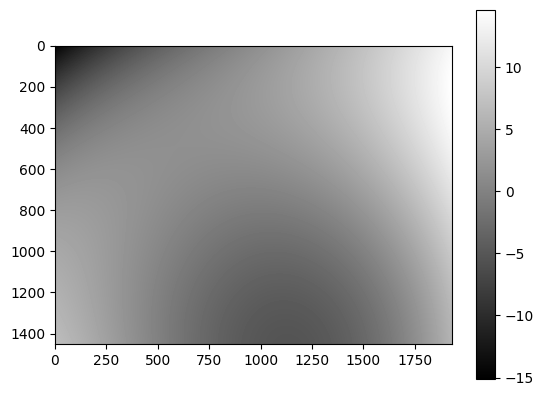

In [30]:
plt.imshow(bg, cmap='gray')
plt.colorbar()

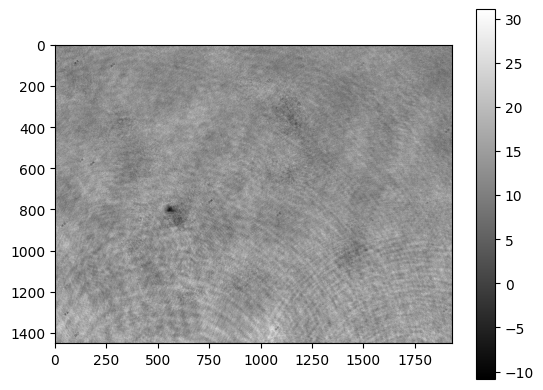

In [37]:
cf = co.first_field_corrected.cpu().numpy() * np.exp(-1j*bg)
plt.imshow(cf.imag, cmap='gray')
plt.colorbar()

In [123]:
phase_img = torch.angle(co.first_field_corrected).cpu().numpy()

In [124]:
An0 = phase_img.copy()
yr, xr = An0.shape

An0 = An0 - An0[0, 0] #Set phase to "0"

# Derivative the phase to handle the modulus
dx = -np.pi + np.mod(np.pi + (np.diff(An0, axis = 0)), 2*np.pi)
dy = -np.pi + np.transpose(np.mod(np.pi + np.transpose((np.diff(An0))), 2*np.pi))

#dx1, dy1 the derivatives
dx1 = 1/2 * ((dx[:, 1:] + dx[:, :-1])).flatten(order='F')
dy1 = 1/2 * ((dy[1:, :] + dy[:-1, :])).flatten(order='F')

#(derivate w.r.t to X and Y respectively.) Each factor have a constant b_i to be fitted later on.
G_end = G.shape[0]
uneven_range = np.arange(1, G_end+1, 2)
even_range = np.arange(0, G_end, 2)

dt = np.zeros(2 * (xr-1) * (yr-1))
dt[even_range] = dx1
dt[uneven_range] = dy1          

# Here the coefficients to the polonomial are calculated. Note that np.linalg.lstsq(b,B)[0] is equivivalent to \ in MATLAB              
R = np.transpose(np.linalg.cholesky(np.matmul(np.transpose(G),G)))

# Equivivalent to R\(R'\(G'*dt))
b = np.linalg.lstsq(R, 
                    np.linalg.lstsq(np.transpose(R),
                                    np.matmul(np.transpose(G),dt), rcond=None)[0], rcond=None)[0]
b = np.asarray(b)

# Phase background is defined by the 4th order polynomial with the fitted parameters.
phase_background = 0
for i, factor in enumerate(poly):
    phase_background = phase_background + b[i]*factor

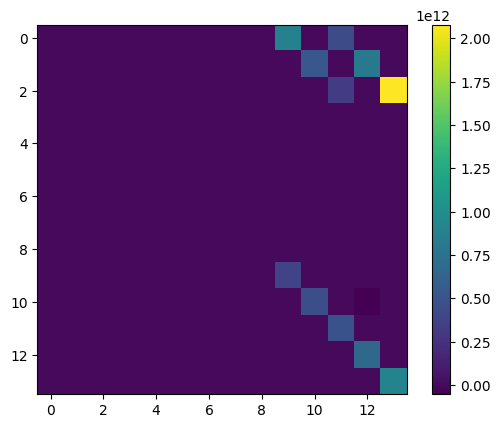

In [125]:
plt.imshow(R)
plt.colorbar()

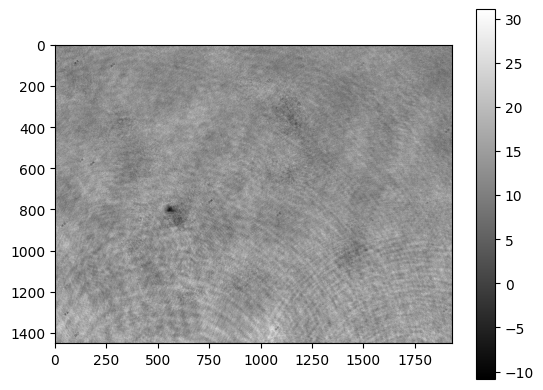

In [128]:
cf = co.first_field_corrected.cpu().numpy() * np.exp(-1j*bg)
plt.imshow(cf.imag, cmap='gray')
plt.colorbar()

In [126]:
plt.imshow(PF2.R.cpu().numpy())

AttributeError: 'PolynomialFitterV2' object has no attribute 'R'

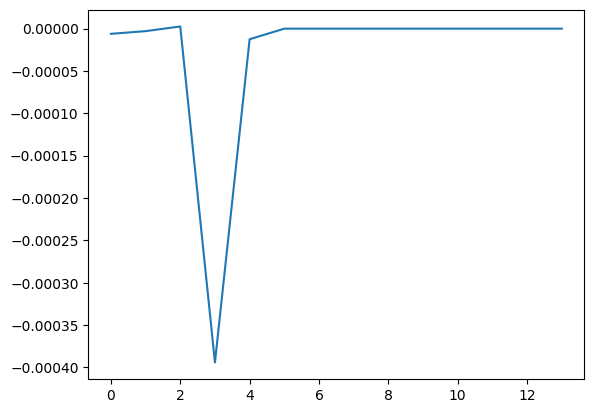

In [130]:
plt.plot(b)
plt.plot(PF2.b.cpu().numpy())
plt.plot(b - PF2.b.cpu().numpy())

In [61]:
PF2.G_matrix

tensor([[-1.4490e+03, -9.6450e+02,  0.0000e+00,  ..., -1.3479e+09,
         -8.9724e+08,  0.0000e+00],
        [ 0.0000e+00, -7.2450e+02, -1.9290e+03,  ..., -1.0125e+09,
         -2.0219e+09, -3.5889e+09],
        [-1.4490e+03, -9.6350e+02,  0.0000e+00,  ..., -1.3452e+09,
         -8.9445e+08,  0.0000e+00],
        ...,
        [ 0.0000e+00,  7.2350e+02,  1.9250e+03,  ...,  1.0076e+09,
          2.0108e+09,  3.5667e+09],
        [ 1.4470e+03,  9.6350e+02,  0.0000e+00,  ...,  1.3433e+09,
          8.9445e+08,  0.0000e+00],
        [ 0.0000e+00,  7.2350e+02,  1.9270e+03,  ...,  1.0087e+09,
          2.0149e+09,  3.5778e+09]], device='cuda:0')

In [62]:
G

array([[-1.44800000e+03, -9.64000000e+02,  0.00000000e+00, ...,
        -1.34562061e+09, -8.95841344e+08,  0.00000000e+00],
       [ 0.00000000e+00, -7.24000000e+02, -1.92800000e+03, ...,
        -1.01061133e+09, -2.01843091e+09, -3.58336538e+09],
       [-1.44600000e+03, -9.64000000e+02,  0.00000000e+00, ...,
        -1.34376202e+09, -8.95841344e+08,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  7.23000000e+02,  1.92800000e+03, ...,
         1.00782151e+09,  2.01564302e+09,  3.58336538e+09],
       [ 1.44800000e+03,  9.64000000e+02,  0.00000000e+00, ...,
         1.34562061e+09,  8.95841344e+08,  0.00000000e+00],
       [ 0.00000000e+00,  7.24000000e+02,  1.92800000e+03, ...,
         1.01061133e+09,  2.01843091e+09,  3.58336538e+09]])

In [68]:
PF2.polynomial[0]

torch.Size([1450, 1930])

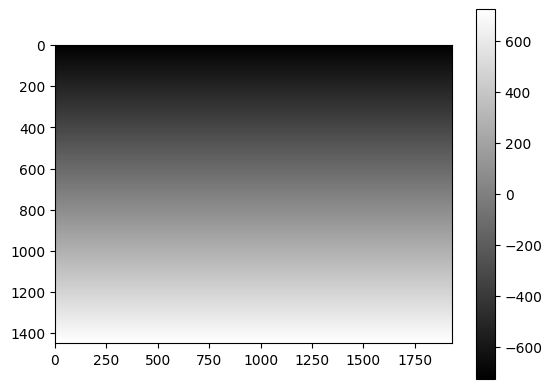

In [76]:
plt.imshow(PF2.polynomial[3].cpu().numpy(), cmap='gray')
plt.colorbar()

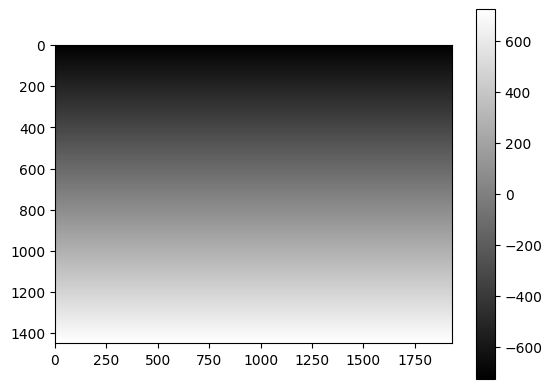

In [77]:
plt.imshow(poly[3], cmap='gray')
plt.colorbar()

In [50]:
np.abs(PF2.G_matrix.cpu().numpy() - G).sum()

1.1153653477773574e+16

In [137]:
import importlib
importlib.reload(ru)

<module 'reconstruction_utils' from 'c:\\Users\\Fredrik\\Documents\\GitHub\\HoloRecPytorch\\notebooks\\../code\\reconstruction_utils.py'>

In [138]:
PF2 = ru.PolynomialFitterV2(shape=input_shape)

In [146]:
bg2=PF2.correct_phase_4order(torch.angle(cf))

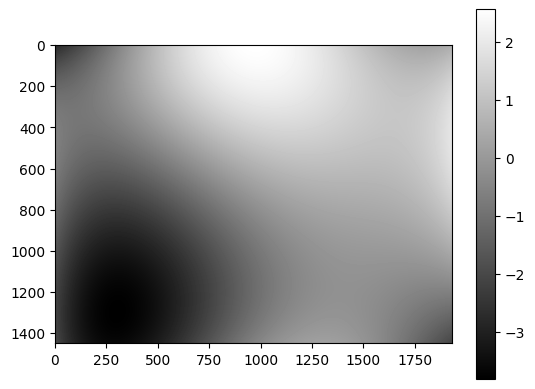

In [147]:
plt.imshow(bg2.cpu().numpy(), cmap='gray')
plt.colorbar()

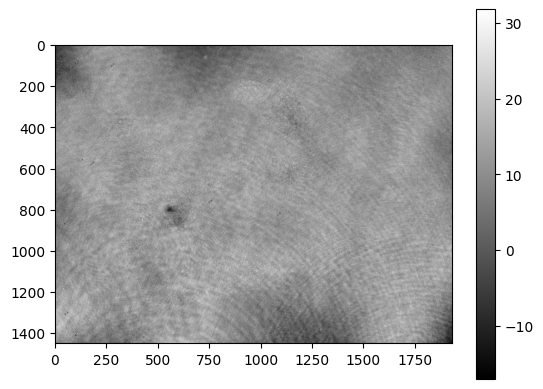

In [148]:
cf = cf * torch.exp(-1j*bg2)
plt.imshow(cf.cpu().numpy().imag, cmap='gray')
plt.colorbar()

In [465]:
co.first_field_corrected

tensor([[ -2.4212+0.8776j,  -0.6819-2.5775j,   0.0700-2.8447j,
          ...,  -6.4182+12.0469j,  -5.6405+10.9009j,
          -4.3213+6.4433j],
        [  0.3247-5.7581j,   4.1206-8.9738j,   5.8486-9.0363j,
          ...,  -9.0569+6.8314j,  -7.2689+4.7479j,
          -4.0176-0.2071j],
        [  1.8525-9.2893j,   6.7247-12.2018j,   8.7424-11.9612j,
          ..., -10.0096+4.2530j,  -8.0620+1.4288j,
          -3.8614-3.8575j],
        ...,
        [ -1.9020+10.4917j,  -5.2072+8.7369j,  -7.4361+10.3063j,
          ...,   7.0220+16.3775j,   5.4505+17.1374j,
           2.0550+14.4432j],
        [ -3.9142+10.3014j,  -6.3931+7.8050j,  -8.1769+8.6363j,
          ...,   2.6435+17.4785j,   1.4320+17.9376j,
          -1.0388+14.8458j],
        [ -4.3412+7.1578j,  -4.9909+3.9533j,  -5.6206+4.0059j,
          ...,  -2.2389+16.3659j,  -2.6738+16.1358j,
          -3.5253+12.3593j]], device='cuda:0')

In [471]:
#downsample co.first_field_corrected with average pooling
f = torch.nn.functional.avg_pool2d(torch.angle(co.first_field_corrected)[None, None, ...], 20, 20)[0, 0, ...]


In [484]:
M = ru.Polynomial2DModel(degree_x=3, degree_y=1, shape=f.shape)

In [485]:
M.fit(z=f)

Fitting a 3x1 polynomial to the data...
Initializing coefficients...
Epoch [100/10000], Loss: 2.9283
Epoch [200/10000], Loss: 2.8840
Epoch [300/10000], Loss: 2.8747
Epoch [400/10000], Loss: 2.8711
Epoch [500/10000], Loss: 2.8690
Epoch [600/10000], Loss: 2.8675
Epoch [700/10000], Loss: 2.8663
Epoch [800/10000], Loss: 2.8654
Epoch [900/10000], Loss: 2.8645
Epoch [1000/10000], Loss: 2.8638
Epoch [1100/10000], Loss: 2.8632
Epoch [1200/10000], Loss: 2.8627
Epoch [1300/10000], Loss: 2.8623
Epoch [1400/10000], Loss: 2.8620
Epoch [1500/10000], Loss: 2.8617
Epoch [1600/10000], Loss: 2.8616
Epoch [1700/10000], Loss: 2.8614
Epoch [1800/10000], Loss: 2.8613
Epoch [1900/10000], Loss: 2.8612
Epoch [2000/10000], Loss: 2.8612
Epoch [2100/10000], Loss: 2.8612
Epoch [2200/10000], Loss: 2.8611
Epoch [2300/10000], Loss: 2.8611
Epoch [2400/10000], Loss: 2.8611
Epoch [2500/10000], Loss: 2.8611
Epoch [2600/10000], Loss: 2.8611
Epoch [2700/10000], Loss: 2.8611
Epoch [2800/10000], Loss: 2.8611
Epoch [2900/1000

In [488]:
import skimage

ModuleNotFoundError: No module named 'skimage'

In [486]:
bg = M.forward()

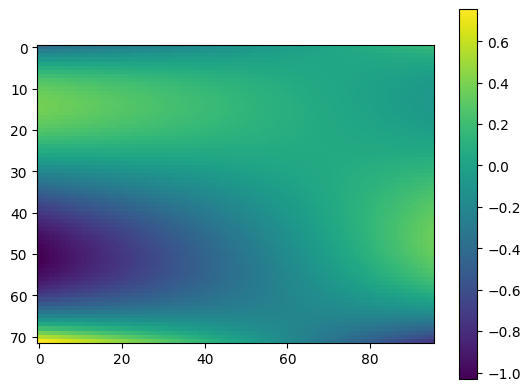

In [487]:
plt.imshow(bg.detach().cpu().numpy())
plt.colorbar()

In [312]:
ph = PR.generate_phase_pattern(num_waves=10, freq_range=(0.5, 1), noise_level=0.0)

AttributeError: 'PolynomialFitterV2' object has no attribute 'generate_phase_pattern'

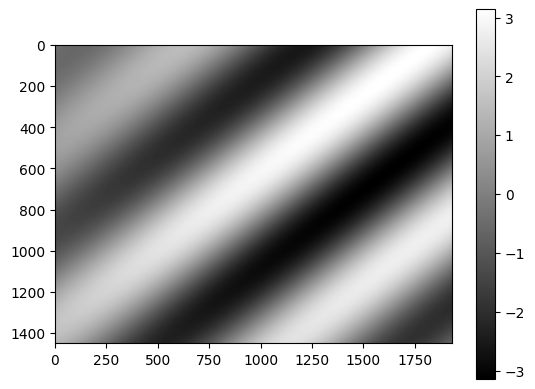

In [263]:
plt.imshow(ph.cpu().numpy(), cmap='gray')
plt.colorbar()

In [264]:
bg2 = PR.fit_background(ph, derivate_phase=True)

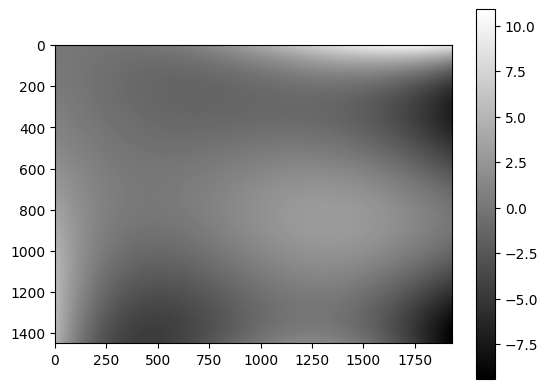

In [265]:
plt.imshow(bg2.cpu().numpy(), cmap='gray')
plt.colorbar()

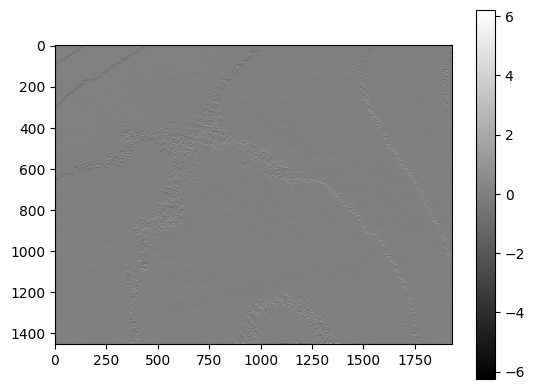

In [35]:
#Take the derivative in x and y of the phase to get rid of the modulation
phase = torch.angle(co.first_field_corrected).cpu().numpy()

phase_x = np.gradient(phase, axis=1)
phase_y = np.gradient(phase, axis=0)

plt.figure()
plt.imshow(phase_y, cmap='gray')
plt.colorbar()

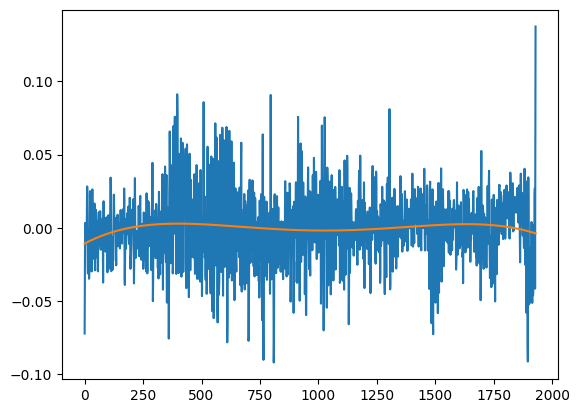

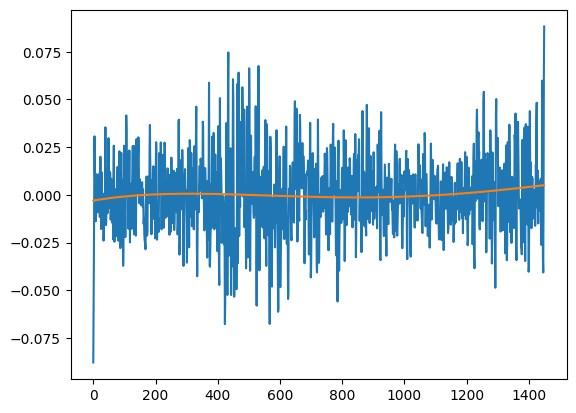

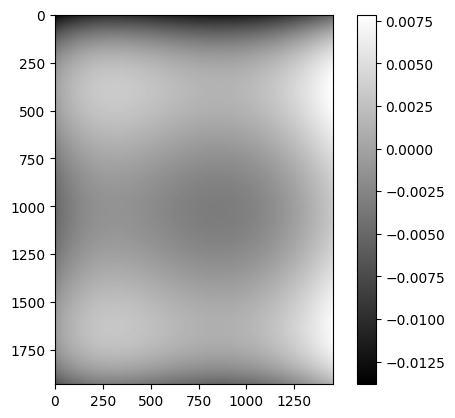

In [37]:
#Fit a 4th order polynomial to the phase derivatives

x = np.arange(phase_x.shape[1])
y = np.arange(phase_y.shape[0])

X, Y = np.meshgrid(x, y)

p_x = np.polyfit(x, phase_x.mean(axis=0), 4)
p_y = np.polyfit(y, phase_y.mean(axis=1), 4)

fit_x = np.polyval(p_x, x)
fit_y = np.polyval(p_y, y)

plt.figure()
plt.plot(phase_x.mean(axis=0))
plt.plot(fit_x)

plt.figure()
plt.plot(phase_y.mean(axis=1))
plt.plot(fit_y)

#To 2d
fit_x = fit_x[:, np.newaxis]
fit_y = fit_y[np.newaxis, :]
fit = fit_x + fit_y

plt.figure()
plt.imshow(fit, cmap='gray')
plt.colorbar()



In [27]:
#plt.figure()
#plt.imshow(co.phase_background.real.cpu().numpy(), cmap='gray')
#plt.colorbar()

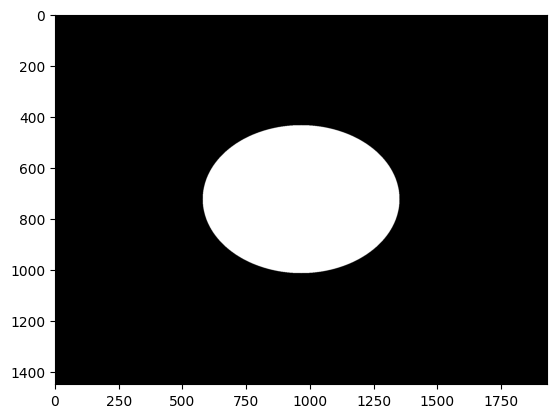

In [28]:
plt.imshow(co.mask_list[0].cpu().numpy(), cmap='gray')

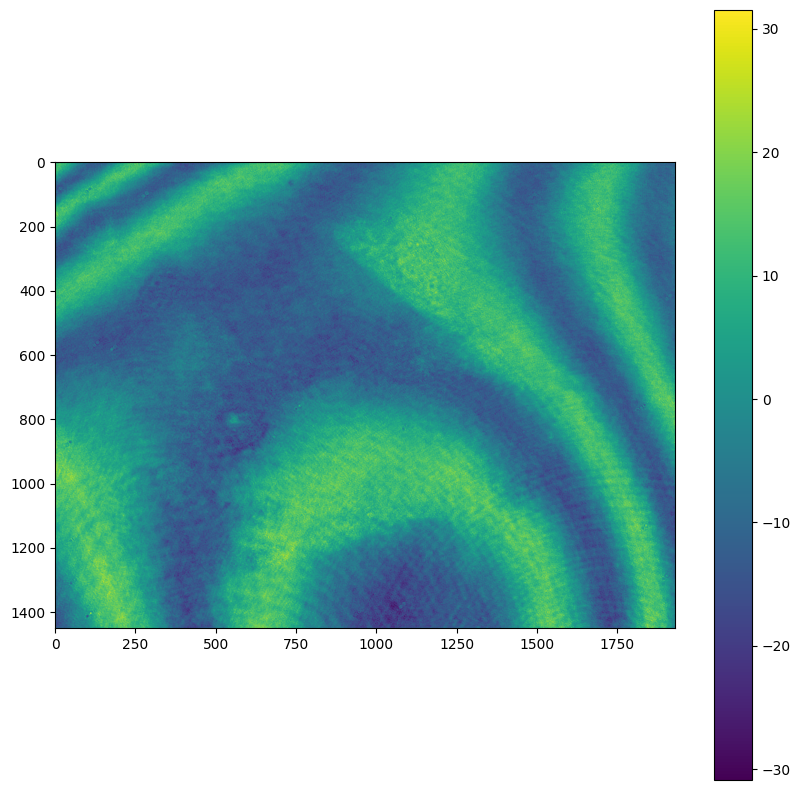

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(datan[10].imag.cpu().numpy())
plt.colorbar()

In [30]:
len(co.mask_list)

3

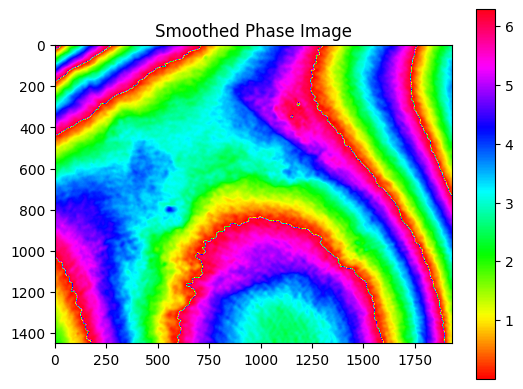

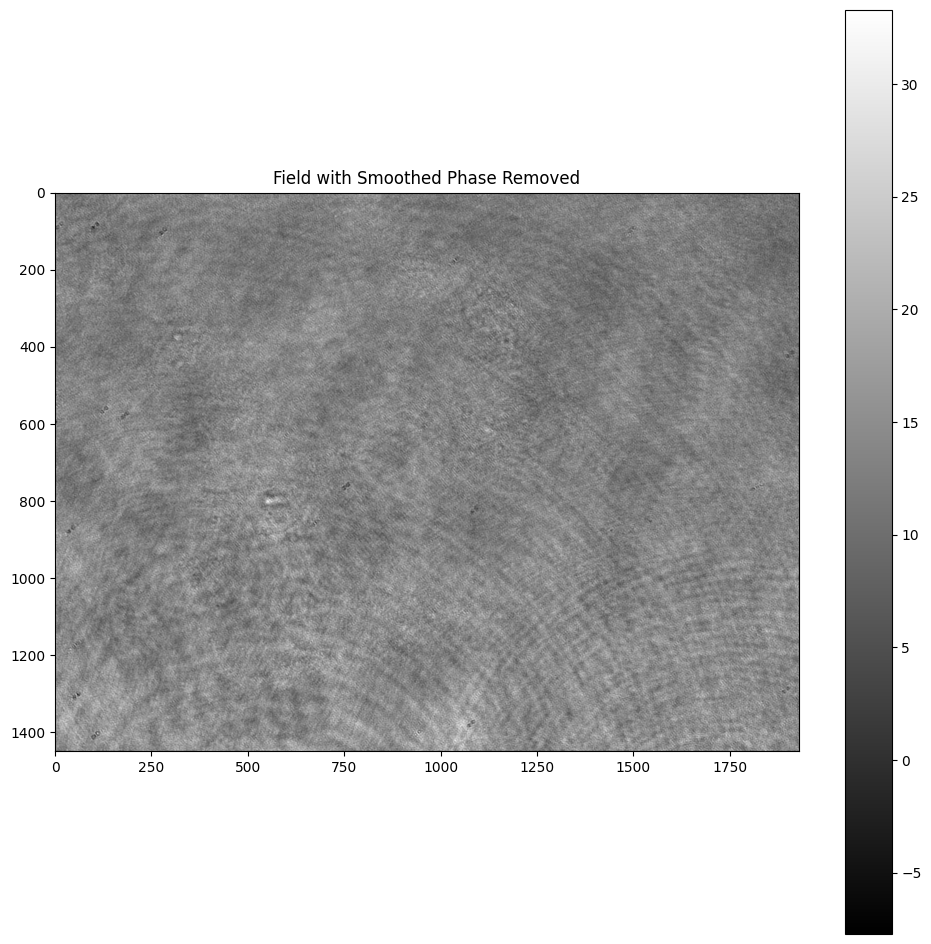

In [31]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


def gaussian_kernel(size: int, sigma: float) -> torch.Tensor:
    """Function to create a Gaussian kernel."""
    coords = torch.arange(size) - size // 2
    x, y = torch.meshgrid(coords, coords)
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel



# Convert phase to complex representation
complex_tensor = co.first_field.unsqueeze(0).to('cpu')

# Define a Gaussian kernel
kernel_size = 21  # Adjust for more/less smoothing
sigma = 5.0
kernel = gaussian_kernel(kernel_size, sigma).view(1, 1, kernel_size, kernel_size)

# Calculate padding
padding = (kernel_size - 1) // 2

# Separate real and imaginary parts
real_part = complex_tensor.real
imag_part = complex_tensor.imag

# Apply Gaussian smoothing
real_smoothed = F.conv2d(real_part.unsqueeze(1), kernel, padding=padding)
imag_smoothed = F.conv2d(imag_part.unsqueeze(1), kernel, padding=padding)

# Combine the smoothed real and imaginary parts
smoothed_complex = torch.complex(real_smoothed.squeeze(1), imag_smoothed.squeeze(1))


# Convert back to phase
smoothed_phase = torch.angle(smoothed_complex)

# Normalize phase to [0, 2π]
smoothed_phase = (smoothed_phase + 2 * np.pi) % (2 * np.pi)

# Display the smoothed phase image
plt.imshow(smoothed_phase.squeeze(), cmap='hsv')
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()

# Remove phase background by subtracting the smoothed phase
# Assuming `co.first_field_corrected` contains the original complex field
# For the sake of example, let's create a dummy `co.first_field_corrected` tensor
# Replace this with the actual field in your application
co_first_field_corrected = co.first_field_corrected.cpu()

# Remove the smoothed phase from the original field
field = co_first_field_corrected * torch.exp(-1j * smoothed_phase)

# Display the real part of the corrected field
plt.figure(figsize=(12, 12))
plt.imshow(field.squeeze().real, cmap='gray')
plt.colorbar()
plt.title('Field with Smoothed Phase Removed')
plt.show()

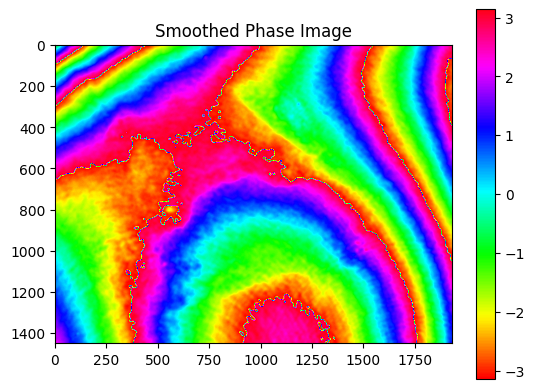

In [32]:
# Display the smoothed phase image
plt.imshow(torch.angle(smoothed_complex).squeeze(), cmap='hsv')
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()

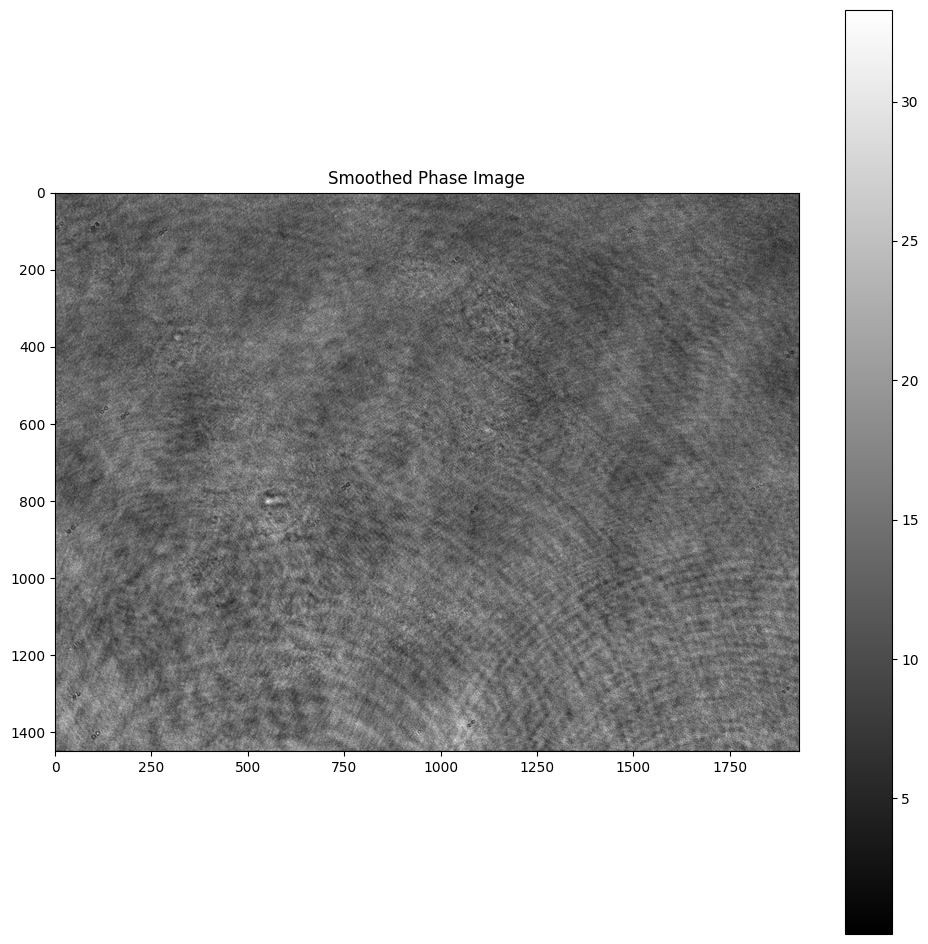

In [33]:
# Display the smoothed phase image
field = co.first_field_corrected.cpu() * torch.exp(-1j*smoothed_phase)

plt.figure(figsize=(12, 12))
plt.imshow(field.squeeze().abs(), cmap='gray')
plt.colorbar()
plt.title('Smoothed Phase Image')
plt.show()